# Extrapolation of QSAR for dopamine D3 receptor ligands to novel scaffolds

The aim of the work documented in this notebook is to investigate the applicability of QSAR to the prediction of the binding affinity of compounds with novel chemical scaffolds. From the ML perspective, it is a problem of extrapolation of a model to out-of-distribution (OOD) observations [1, 2]. This problem is highly relevant to assessing the applicability of QSAR models to the exploration of the novel chemical space.

In this notebook:
1. Bioactivities and chemical structures from ChEMBL are curated
2. Compounds are clustered by scaffolds and separated accordingly into groups (distributions)
3. Deep GNN model is created
4. The model is trained and validated in two data regimes:
    - IID regime with train/validation/test observations sampled from same distributions (same scaffold clusters)
    - OOD regime with train/validation/test observations sampled from random distributions (different scaffold clusters)
5. The distributionally robust optimization [2] is used to improve model performance in OOD regime
6. The results are compared and concluded

**References**
1. Balestriero, Randall, Jerome Pesenti, and Yann LeCun. "Learning in high dimension always amounts to extrapolation." arXiv preprint arXiv:2110.09485 (2021).
2. Krueger, David, et al. "Out-of-distribution generalization via risk extrapolation (rex)." International Conference on Machine Learning. PMLR, 2021.

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn. preprocessing import StandardScaler

from tqdm.auto import tqdm

from rdkit.Chem.rdmolops import RemoveHs

In [2]:
from utils.data_processing import ChemBLDataset
from utils.clustering import cluster_by_scaffold, plot_tsne

## Data Curation

I start with a file containing molecules and their bioactivities downloaded from ChEMBL. The SMILES were converted to MOL with ChmeAxon Standardizer.

In [3]:
standardized_sdf = 'D3_ChemBL.sdf'

In [4]:
try:
    cache = pd.read_pickle('cache_%s.pkl'%standardized_sdf)
    bioactivities, observation_counts, descriptors_df = cache
except:
    data_curator = ChemBLDataset(standardized_sdf)
    bioactivities, observation_counts, descriptors_df = data_curator.get_curated(
        assays_thershold=5,
        mol_hash='descriptor')
    pd.to_pickle((bioactivities, observation_counts, descriptors_df), 
                 'cache_%s.pkl'%standardized_sdf)

### Descriptors

In [5]:
pca_pipeline = make_pipeline(StandardScaler(), PCA(32))
descs_pca = pca_pipeline.fit_transform(descriptors_df)
descs_pca = pd.DataFrame(index=descriptors_df.index, data=descs_pca)

## Clustering and feature space

The compounds are clustered by scaffolds with ScaffoldTree algorithm. The largest 10 clusters are kept and considered as clusters of compounds sampled from separate distributions.

In [6]:
labels, full_labels = cluster_by_scaffold(bioactivities, descriptors_df, n_clusters=10)

ScaffoldTree:   0%|                                    | 0/3704 [00:00<?, ?it/s]

In [7]:
top_scaffold_cls = pd.DataFrame(full_labels).value_counts().head(10).index
top_scaffold_cls = np.concatenate(top_scaffold_cls)

In [8]:
bioactivities['cluster'] = full_labels
bioactivities = bioactivities[bioactivities['cluster'].isin(top_scaffold_cls)]

In [9]:
labels = bioactivities['cluster']

In [10]:
descriptors_df = descriptors_df.loc[bioactivities['mol_hash']]

Compounds are visualized in TSNE-reduced descriptor space to show the similarity of different clusters (colors).

/home/mikolaj_mizera/anaconda3/envs/pygeom/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


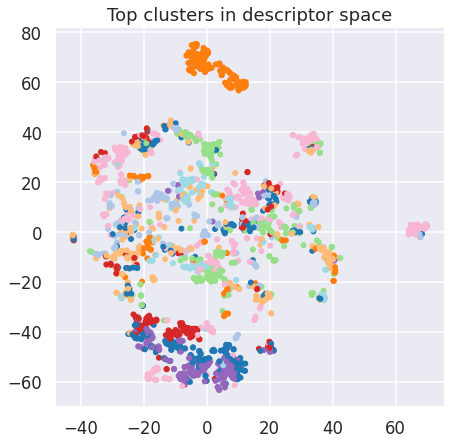

In [11]:
plot_tsne(bioactivities, descriptors_df, bioactivities['cluster'])

### Target (pKi affinity) distribution

<AxesSubplot:xlabel='mean', ylabel='Count'>

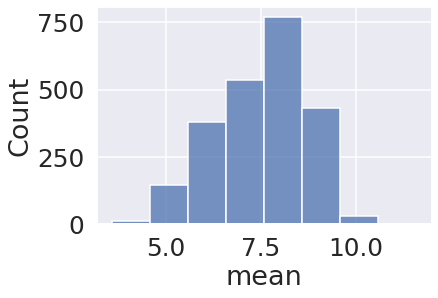

In [12]:
sns.set('talk', font_scale=1.5)
sns.histplot(bioactivities['mean'], discrete=True)

### Dataset with molecular graphs 

In [13]:
import torch
from torch_geometric.datasets.molecule_net import x_map, e_map
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

/home/mikolaj_mizera/anaconda3/envs/pygeom/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [14]:
prop_mappings = {
    'atomic_num': lambda x: x.GetAtomicNum(),
    'chirality': lambda x: str(x.GetChiralTag()),
    'degree': lambda x: x.GetTotalDegree(),
    'formal_charge': lambda x: x.GetFormalCharge(),
    'num_hs': lambda x: x.GetTotalNumHs(),
    'num_radical_electrons': lambda x: x.GetNumRadicalElectrons(),
    'hybridization': lambda x: str(x.GetHybridization()),
    'is_aromatic': lambda x: x.GetIsAromatic(),
    'is_in_ring': lambda x: x.IsInRing(),
    'bond_type': lambda x: str(x.GetBondType()),
    'stereo': lambda x: str(x.GetStereo()),
    'is_conjugated': lambda x: x.GetIsConjugated()
}

In [15]:
# Adapted form torch_geometric.datasets import MoleculeNet

def mol_to_graph(x):
        
    mol = x.loc['mols']
    y = x.loc['mean']
    mol_hash = x.loc['mol_hash']
    cluster = x.loc['cluster']
    
    # Descriptors are currently not used in training but left for compatibility
    desc_vec = descs_pca.loc[mol_hash].values[None, :]
    desc_vec = torch.tensor(desc_vec)
    
    # map atom properties to node features
    node_features = [[x_map[k].index(att(atom)) 
                      for k, att in prop_mappings.items()
                         if k in x_map.keys()]
                             for atom in mol.GetAtoms()]
    
    x = torch.tensor(node_features, dtype=torch.long).view(-1, 9)

    # map bond properties to edge features
    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = [e_map[k].index(att(bond)) 
             for k, att in prop_mappings.items()
                if k in e_map.keys()]

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)

    if edge_index.numel() > 0:
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, 
                desc=desc_vec, cluster=cluster)

    return data

In [16]:
dataset = bioactivities[['mol_hash', 'mols', 'mean', 'cluster']].apply(mol_to_graph, axis=1).values

In [17]:
num_node_features = dataset[0].x.shape[1]
num_edge_features = int(dataset[0].edge_attr.shape[-1])
descs_comp = dataset[0].desc.shape[-1]

## Graph-based neural model

The GNN will quantitatively model the relationship between chemical structure and binding affinity to a dopamine receptor. 

The design assumptions are: 
 - use 3 convolutional layers with an attention mechanism to aggregate features from 3rd neighbor-of-neighbor of each node (atom) in a graph
 - use normalization of graph nodes to prevent over-smoothing
 - get graph-level embeddings with a global pooling operator
 - predict binding affinity with graph embeddings as features
 - use MC dropout to model uncertainty of prediction

In [18]:
from torch.nn import Linear, BatchNorm1d, Dropout, ReLU
import torch.nn.functional as F

from torch_geometric.nn import GATv2Conv, TopKPooling, PairNorm
from torch_geometric.nn import global_mean_pool, global_max_pool

In [19]:
class DopamineGAT(torch.nn.Module):
    
    def __init__(self, num_features, num_edge_features, 
                 gat_hidden_size=8, 
                 edge_nn_hidden_size=8,
                 dense_hidden_size=32,
                 n_gat_heads=3):
        
        super(DopamineGAT, self).__init__()
        torch.manual_seed(42)
        
        ### Graph embedding block
        self.conv_1 = GATv2Conv(num_features, 
                                gat_hidden_size, 
                                edge_dim=num_edge_features, 
                                dropout=0.2,
                                heads=n_gat_heads)
        self.pool_1 = TopKPooling(n_gat_heads * gat_hidden_size, ratio=0.75)
        self.pair_norm_1 = PairNorm(n_gat_heads * gat_hidden_size)
                
        self.conv_2 = GATv2Conv(n_gat_heads * gat_hidden_size, 
                                gat_hidden_size, 
                                edge_dim=num_edge_features,
                                dropout=0.2,
                                heads=n_gat_heads)        
        self.pool_2 = TopKPooling(n_gat_heads * gat_hidden_size, ratio=0.75)
        self.pair_norm_2 = PairNorm(n_gat_heads * gat_hidden_size)
        
        self.conv_3 = GATv2Conv(n_gat_heads * gat_hidden_size, 
                                gat_hidden_size, 
                                edge_dim=num_edge_features,
                                dropout=0.2,
                                heads=n_gat_heads)        
        self.pool_3 = TopKPooling(n_gat_heads * gat_hidden_size, ratio=0.75)
        self.pair_norm_3 = PairNorm(n_gat_heads * gat_hidden_size)
        
        ### Estimator block
        self.dropout_desc = Dropout(p=0.2)
        self.dropout_dense = Dropout(p=0.2)
        
        descs_comp=0
        self.batch_norm_1 = BatchNorm1d(2 * n_gat_heads * gat_hidden_size + descs_comp)        
        self.hidden_dense = Linear(2 * n_gat_heads * gat_hidden_size + descs_comp, dense_hidden_size)
        self.batch_norm_2 = BatchNorm1d(dense_hidden_size)
        self.out = Linear(dense_hidden_size, 1)
        
    def forward(self, x, edge_index, edge_attr, batch_index, desc_pca):
        
        ### Graph embedding block
        nn = F.relu(self.conv_1(x, edge_index, edge_attr))   
        nn, edge_index, edge_attr, batch_index, _, _ = self.pool_1(nn, edge_index, edge_attr, batch_index)
        nn = self.pair_norm_1(nn, batch_index)        
        
        nn = F.relu(self.conv_2(nn, edge_index, edge_attr))
        nn, edge_index, edge_attr, batch_index, _, _ = self.pool_2(nn, edge_index, edge_attr, batch_index)
        nn = self.pair_norm_2(nn, batch_index)
        
        nn = F.relu(self.conv_3(nn, edge_index, edge_attr))
        nn, edge_index, edge_attr, batch_index, _, _ = self.pool_3(nn, edge_index, edge_attr, batch_index)
        nn = self.pair_norm_3(nn, batch_index)
                
        embedding = torch.cat([global_mean_pool(nn, batch_index), 
                               global_max_pool(nn, batch_index)], dim=1)
        
        ### Estimator block
        nn = embedding        
        
        #desc_pca = self.dropout_desc(desc_pca)
        
        #nn = torch.cat([nn, desc_pca], axis=-1)     
        nn = self.batch_norm_1(nn)     

        nn = self.hidden_dense(nn)
        nn = self.dropout_dense(nn)
        nn = self.batch_norm_2(nn)   
        
        nn = F.relu(nn)
        
        out = self.out(nn)
        
        return out, embedding        

## Training and validation

Two validation scenarios are performed:
 - optimistic scenario, in which train/validation/test splits have similarly distributed samples (IID)
 - realistic scenario, in which train/validation/test splits contain observations sampled from dissimilar distributions (ex. compounds have different scaffolds)

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from utils.model_eval import train, dro_train, predict, metric

In [21]:
data_size = len(dataset)
BATCH_SIZE = 64
EPOCHS = 10000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
def train_val_test_loop(train_loader, val_loader, test_loader,
                        epochs=2000, early_stop_patience=15,
                        train_fcn=train):
    
    model = DopamineGAT(num_node_features, num_edge_features,
                        gat_hidden_size=8,
                        dense_hidden_size=32,
                        n_gat_heads=5)
    model = model.to(device)
    
    # Keep model in training mode to use MC dropout confidence estimation
    model.train() 
    
    loss_f = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    stats = {'loss': [], 'q2_train': [], 'q2_val': [], 'q2_val_conf': []}

    early_stop_scores = []
    best_state = model.state_dict()
    
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        
        loss = train_fcn(model, train_loader, loss_f, optimizer, epoch)
        
        # Validate the model and early stop if triggered
        if epoch%10 == 0:
            
            q2_train, _ = metric(model, train_loader)
            
            q2_val, q2_val_confident = metric(model, val_loader)
            
            early_stop_scores.append(q2_val)   

            if (np.argmax(np.flip(early_stop_scores)) > early_stop_patience):
                break

            if np.max(early_stop_scores) == early_stop_scores[-1]:
                best_state = model.state_dict()

            stats['loss'].append(loss.detach().numpy())
            stats['q2_train'].append(q2_train)
            stats['q2_val'].append(q2_val)
            stats['q2_val_conf'].append(q2_val_confident)

        report = (loss, q2_train, q2_val, q2_val_confident)
        
        pbar.set_description('Loss: %.3f | Train: %.3f  | Val: %.3f | Val(conf): %.3f'%report)
    
    model.load_state_dict(best_state)
    q2_test, q2_test_confident = metric(model, test_loader)
    
    return q2_test, q2_test_confident, stats

In [23]:
def plot_stats(stats):
    df = pd.DataFrame(index=stats.keys(), data=stats.values())
    df = df.loc[['q2_train', 'q2_val', 'q2_val_conf']].T   
    df.plot(logy=True)
    plt.show()

### Test scenarios

#### Cross validation with similarly distributed training/validation samples

In [24]:
def iid_test(train_fcn):
    
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
    
    # The folds are stratified by target values
    quants = np.array(pd.qcut([x.y for x in dataset], 5, labels=range(5), retbins=False))
    splits = sss.split(np.arange(len(dataset)), labels)
    
    q2_test_scores = []
    q2_test_confident_scores = []
    
    for fold_id, (train_val_index, test_index) in enumerate(splits):

        # Validation set for early stopping / hyperparameters optimization
        train_val_data = dataset[train_val_index]

        train_index, val_index = train_test_split(train_val_index, test_size=0.2,
                                                  stratify=np.array([x.cluster for x in train_val_data]))    

        train_loader = DataLoader(dataset[train_index], batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(dataset[val_index], batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(dataset[test_index], batch_size=BATCH_SIZE, shuffle=True)

        q2_test, q2_test_confident, stats = train_val_test_loop(train_loader, val_loader, test_loader,
                                                                epochs=EPOCHS, early_stop_patience=15, 
                                                                train_fcn=train_fcn)

        print('Fold %d | Test Q2: %.3f |  Test Q2 (1/4 most confident): %.3f'%(fold_id, 
                                                                               q2_test, q2_test_confident))
        plot_stats(stats)
        
        q2_test_scores.append(q2_test)
        q2_test_confident_scores.append(q2_test_confident_scores)
    
    return q2_test, q2_test_confident, stats

#### Cross validation with training/validation sets sampled from dissimilar distributions

In [25]:
def ood_test(train_fcn):

    clusters = pd.DataFrame(labels).value_counts().iloc[:5]

    for fold_id, test_cluster in enumerate(np.concatenate(clusters.index)):

        # Validation set for early stopping / hyperparameters optimization
        train_val_data = [r for r in dataset if r.cluster!=test_cluster]
        val_cluster = np.random.choice(np.array([x.cluster for x in train_val_data]))

        train_data = [r for r in train_val_data if r.cluster!=val_cluster]
        val_data = [r for r in train_val_data if r.cluster==val_cluster]    
        test_data = [r for r in dataset if r.cluster==test_cluster]

        train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

        q2_test, q2_test_confident, stats = train_val_test_loop(train_loader, val_loader, test_loader,
                                                                epochs=EPOCHS, early_stop_patience=15, 
                                                                train_fcn=train_fcn)

        print('Fold %d | Test Q2: %.3f |  Test Q2 (1/4 most confident): %.3f'%(fold_id, q2_test, 
                                                                               q2_test_confident))
        plot_stats(stats)
    
    return q2_test, q2_test_confident, stats

#### IID observations / regular training loop

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 0 | Test Q2: 0.552 |  Test Q2 (1/4 most confident): 0.645


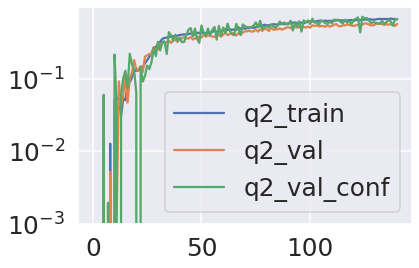

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 1 | Test Q2: 0.584 |  Test Q2 (1/4 most confident): 0.632


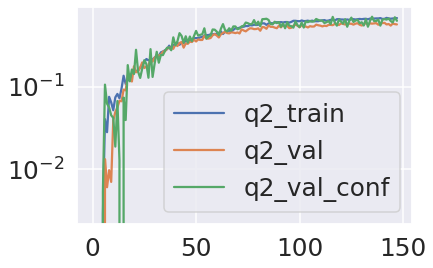

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 2 | Test Q2: 0.510 |  Test Q2 (1/4 most confident): 0.504


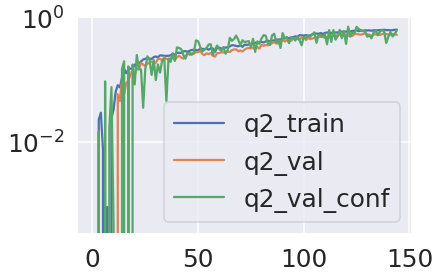

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 3 | Test Q2: 0.559 |  Test Q2 (1/4 most confident): 0.638


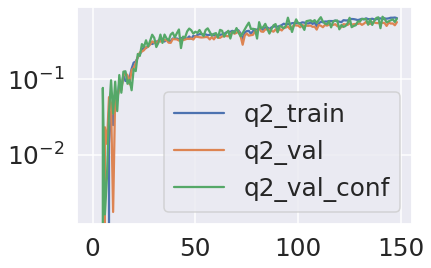

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 4 | Test Q2: 0.539 |  Test Q2 (1/4 most confident): 0.640


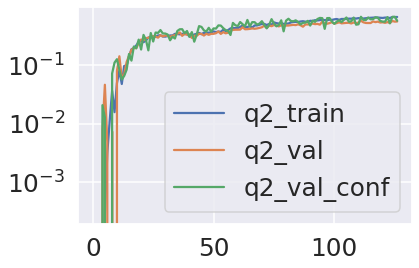

In [26]:
iid_test_reg_train_res = iid_test(train)

#### OOD observations / regular training loop

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 0 | Test Q2: 0.362 |  Test Q2 (1/4 most confident): 0.426


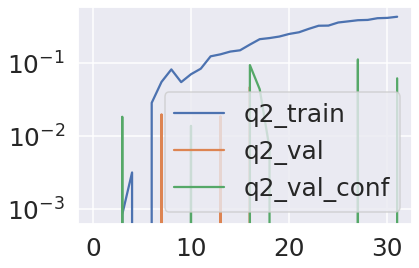

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 1 | Test Q2: 0.183 |  Test Q2 (1/4 most confident): 0.155


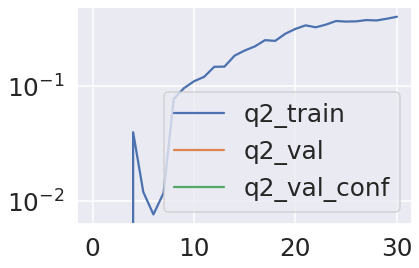

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 2 | Test Q2: 0.006 |  Test Q2 (1/4 most confident): -0.909


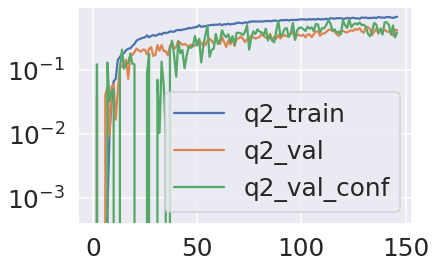

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 3 | Test Q2: 0.076 |  Test Q2 (1/4 most confident): 0.104


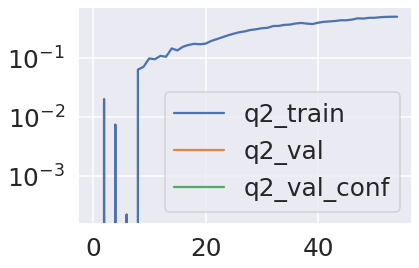

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 4 | Test Q2: -0.483 |  Test Q2 (1/4 most confident): -0.485


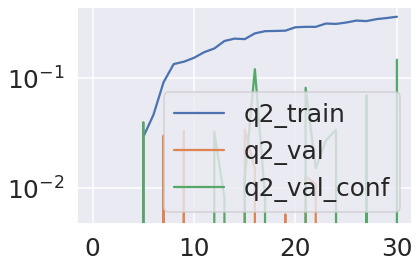

In [27]:
ood_test_reg_train_res = ood_test(train)

## Distributionally robust optimization

#### OOD observations / DRO training loop

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 0 | Test Q2: 0.078 |  Test Q2 (1/4 most confident): 0.123


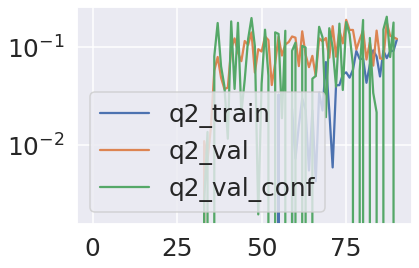

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 1 | Test Q2: 0.044 |  Test Q2 (1/4 most confident): -0.018


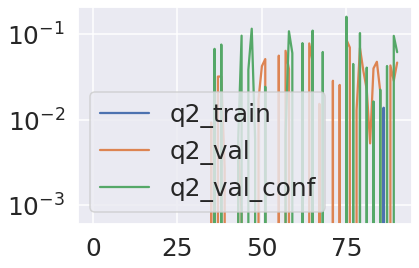

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 2 | Test Q2: -0.272 |  Test Q2 (1/4 most confident): -0.225


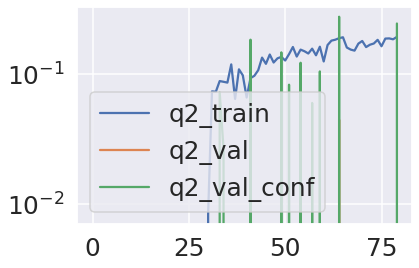

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 3 | Test Q2: -0.041 |  Test Q2 (1/4 most confident): 0.011


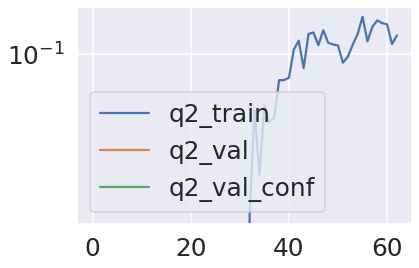

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold 4 | Test Q2: -0.649 |  Test Q2 (1/4 most confident): -0.614


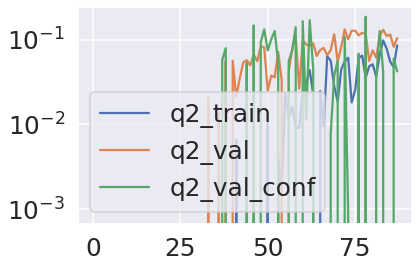

In [33]:
ood_test_dro_train_res = ood_test(dro_train)

## Results

1. A test of the model in the IID data regime: 
 - model achieves Q2 0.55 (+/- 0.02) on the test set
 - validation score of the model is a good indicator of the expected testing score
2. A test of the model in the OOD data regime:
 - model achieves Q2 0.03 (+/- 0.28) on the test set
 - validation score is not a reliable indicator of the expected test score
3. A test of the model in OOD data regime with DRO training:
 - model achieves Q2 -0.17 (+/- 0.26)
 - validation score of the model is more realistic indicator of the expected testing score than in regular training

## Conclusions

1. The same data domain for both development and production datasets is a necessary condition for reliable model execution.
2. The usefulness of training by distributionally robust optimization in the OOD data regime is limited to a more realistic indication of expected statistical characteristics in production. Based on performed tests, there is no strong incentive to use DRO to improve generalization to the novel scaffolds, and more work should be done to improve the method. Possibly, better performance of the DRO approach may be achieved with more expressive model architecture or longer training times. 
3. For a model trained and tested in the IID data regime, confidence estimation with the Monte Carlo Dropout approach allows to select more reliable predictions and achieve better statistical characteristics for them. Reliable confidence estimation may be important for reducing False Positive Rate in virtual screening.